## Project Description

We present a transformer-based architecture for handwriting text recognition with a lightweight convolutional encoder. Our experiments show that simple encoders are more accurate in HTR tasks in comparision with such encoders as ResNet50. In this notebook, we present an implementation of the following architecture:

![picture](https://github.com/conwerner/ocr-transformer/raw/master/diagram_model2.png)

github: https://github.com/conwerner/ocr-transformer

Besides, we publish our pretrained weights with 0.37 word error rate on the Cyrillic Handwriting Dataset. Weights were learnt on synthetic data + real data. Synthetic data is generated with this library https://github.com/conwerner/shiftlab_ocr

In [1]:
!pip install Augmentor editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 21.2 MB/s eta 0:00:00


In [2]:
import os
import random
import string
import math
from collections import Counter
from time import time

import Augmentor
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, LeakyReLU
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import editdistance
from tqdm import tqdm

## Const

In [3]:
DIR = './' # work directory
PATH_TEST_DIR = '../input/cyrillic-handwriting-dataset/test/'
PATH_TEST_LABELS =  '../input/cyrillic-handwriting-dataset/test.tsv'
PATH_TRAIN_DIR =  '../input/cyrillic-handwriting-dataset/train/'
PATH_TRAIN_LABELS =  '../input/cyrillic-handwriting-dataset/train.tsv'
PREDICT_PATH = "../input/cyrillic-handwriting-dataset/test/"
CHECKPOINT_PATH = DIR
WEIGHTS_PATH =  "../input/simple-and-efficient-transformer-ocr-weights/ocr_transformer_4h2l_simple_conv_64x256.pt"
PATH_TEST_RESULTS = DIR+'/test_result.tsv'
TRAIN_LOG = DIR+'train_log.tsv'

## Config

In [11]:
### MODEL ### 
MODEL = 'model2'
HIDDEN = 512
ENC_LAYERS = 2
DEC_LAYERS = 2
N_HEADS = 4
LENGTH = 42
ALPHABET = ['PAD', 'SOS', ' ', '!', '"', '%', '(', ')', ',', '-', '.', '/',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
            '[', ']', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И',
            'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х',
            'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е',
            'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т',
            'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            'ё', 'EOS']
            
### TRAINING ###
BATCH_SIZE = 16
DROPOUT = 0.2
N_EPOCHS = 3 # 128
CHECKPOINT_FREQ = 10 # save checkpoint every 10 epochs
DEVICE = 'cuda:0' # or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
SCHUDULER_ON = True # "ReduceLROnPlateau"
PATIENCE = 5 # for ReduceLROnPlateau
OPTIMIZER_NAME = 'Adam' # or "SGD"
LR = 2e-6

### TESTING ###
CASE = False # is case taken into account or not while evaluating
PUNCT = False # are punctuation marks taken into account

### INPUT IMAGE PARAMETERS ###
WIDTH = 256
HEIGHT = 64
CHANNELS = 1 # 3 channels if model1

## Utils

In [5]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.scale = torch.nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x) 

    
# convert images and labels into defined data structures
def process_data(image_dir, labels_dir, ignore=[]):
    """
    params
    ---
    image_dir : str
      path to directory with images
    labels_dir : str
      path to tsv file with labels
    returns
    ---
    img2label : dict
      keys are names of images and values are correspondent labels
    chars : list
      all unique chars used in data
    all_labels : list
    """

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split('\t')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char)
        except:
            print('ValueError:', x)
            pass

    all_labels = sorted(list(set(list(img2label.values()))))
    chars.sort()
    chars = ['PAD', 'SOS'] + chars + ['EOS']

    return img2label, chars, all_labels


# TRANSLATE INDICIES TO TEXT
def indicies_to_text(indexes, idx2char):
    text = "".join([idx2char[i] for i in indexes])
    text = text.replace('EOS', '').replace('PAD', '').replace('SOS', '')
    return text


# COMPUTE CHARACTER ERROR RATE
def char_error_rate(p_seq1, p_seq2):
    """
    params
    ---
    p_seq1 : str
    p_seq2 : str
    returns
    ---
    cer : float
    """
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))


# RESIZE AND NORMALIZE IMAGE
def process_image(img):
    """
    params:
    ---
    img : np.array
    returns
    ---
    img : np.array
    """
    w, h, _ = img.shape
    new_w = HEIGHT
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = WIDTH
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img


# GENERATE IMAGES FROM FOLDER
def generate_data(img_paths):
    """
    params
    ---
    names : list of str
        paths to images
    returns
    ---
    data_images : list of np.array
        images in np.array format
    """
    data_images = []
    for path in tqdm(img_paths):
        img = np.asarray(Image.open(path).convert('RGB'))
        try:
            img = process_image(img)
            data_images.append(img.astype('uint8'))
        except:
            print(path)
            img = process_image(img)
    return data_images


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def evaluate(model, criterion, loader, case=True, punct=True):
    """
    params
    ---
    model : nn.Module
    criterion : nn.Object
    loader : torch.utils.data.DataLoader

    returns
    ---
    epoch_loss / len(loader) : float
        overall loss
    """
    model.eval()
    metrics = {'loss': 0, 'wer': 0, 'cer': 0}
    result = {'true': [], 'predicted': [], 'wer': []}
    with torch.no_grad():
        for (src, trg) in loader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            logits = model(src, trg[:-1, :])
            loss = criterion(logits.view(-1, logits.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
            out_indexes = model.predict(src)
            
            true_phrases = [indicies_to_text(trg.T[i][1:], ALPHABET) for i in range(BATCH_SIZE)]
            pred_phrases = [indicies_to_text(out_indexes[i], ALPHABET) for i in range(BATCH_SIZE)]
            
            if not case:
                true_phrases = [phrase.lower() for phrase in true_phrases]
                pred_phrases = [phrase.lower() for phrase in pred_phrases]
            if not punct:
                true_phrases = [phrase.translate(str.maketrans('', '', string.punctuation))\
                                for phrase in true_phrases]
                pred_phrases = [phrase.translate(str.maketrans('', '', string.punctuation))\
                                for phrase in pred_phrases]
            
            metrics['loss'] += loss.item()
            metrics['cer'] += sum([char_error_rate(true_phrases[i], pred_phrases[i]) \
                        for i in range(BATCH_SIZE)])/BATCH_SIZE
            metrics['wer'] += sum([int(true_phrases[i] != pred_phrases[i]) \
                        for i in range(BATCH_SIZE)])/BATCH_SIZE

            for i in range(len(true_phrases)):
              result['true'].append(true_phrases[i])
              result['predicted'].append(pred_phrases[i])
              result['wer'].append(char_error_rate(true_phrases[i], pred_phrases[i]))

    for key in metrics.keys():
      metrics[key] /= len(loader)

    return metrics, result


# MAKE PREDICTION
def prediction(model, test_dir, char2idx, idx2char):
    """
    params
    ---
    model : nn.Module
    test_dir : str
        path to directory with images
    char2idx : dict
        map from chars to indicies
    id2char : dict
        map from indicies to chars

    returns
    ---
    preds : dict
        key : name of image in directory
        value : dict with keys ['p_value', 'predicted_label']
    """
    preds = {}
    os.makedirs('/output', exist_ok=True)
    model.eval()

    with torch.no_grad():
        for filename in os.listdir(test_dir):
            img = Image.open(test_dir + filename).convert('RGB')

            img = process_image(np.asarray(img)).astype('uint8')
            img = img / img.max()
            img = np.transpose(img, (2, 0, 1))

            src = torch.FloatTensor(img).unsqueeze(0).to(DEVICE)
            if CHANNELS == 1:
              src = transforms.Grayscale(CHANNELS)(src)
            out_indexes = model.predict(src)
            pred = indicies_to_text(out_indexes[0], idx2char)
            preds[filename] = pred

    return preds


class ToTensor(object):
    def __init__(self, X_type=None, Y_type=None):
        self.X_type = X_type

    def __call__(self, X):
        X = X.transpose((2, 0, 1))
        X = torch.from_numpy(X)
        if self.X_type is not None:
            X = X.type(self.X_type)
        return X


def log_config(model):
    print('transformer layers: {}'.format(model.enc_layers))
    print('transformer heads: {}'.format(model.transformer.nhead))
    print('hidden dim: {}'.format(model.decoder.embedding_dim))
    print('num classes: {}'.format(model.decoder.num_embeddings))
    print('backbone: {}'.format(model.backbone_name))
    print('dropout: {}'.format(model.pos_encoder.dropout.p))
    print(f'{count_parameters(model):,} trainable parameters')


def log_metrics(metrics, path_to_logs=None):
    if path_to_logs != None:
      f = open(path_to_logs, 'a')
    if metrics['epoch'] == 1:
      if path_to_logs != None:
        f.write('Epoch\tTrain_loss\tValid_loss\tCER\tWER\tTime\n')
      print('Epoch   Train_loss   Valid_loss   CER   WER    Time    LR')
      print('-----   -----------  ----------   ---   ---    ----    ---')
    print('{:02d}       {:.2f}         {:.2f}       {:.2f}   {:.2f}   {:.2f}   {:.7f}'.format(\
        metrics['epoch'], metrics['train_loss'], metrics['loss'], metrics['cer'], \
        metrics['wer'], metrics['time'], metrics['lr']))
    if path_to_logs != None:
      f.write(str(metrics['epoch'])+'\t'+str(metrics['train_loss'])+'\t'+str(metrics['loss'])+'\t'+str(metrics['cer'])+'\t'+str(metrics['wer'])+'\t'+str(metrics['time'])+'\n')
      f.close()
        

# plot images
def show_img_grid(images, labels, N):
    n = int(N**(0.5))
    k = 0
    f, axarr = plt.subplots(n,n,figsize=(10,10))
    for i in range(n):
        for j in range(n):
            axarr[i,j].set_title(labels[k])
            axarr[i,j].imshow(images[k])
            k += 1

## Dataset

In [6]:
# text to array of indicies
def text_to_labels(s, char2idx):
    return [char2idx['SOS']] + [char2idx[i] for i in s if i in char2idx.keys()] + [char2idx['EOS']]

# store list of images' names (in directory) and does some operations with images
class TextLoader(torch.utils.data.Dataset):
    def __init__(self, images_name, labels, transforms, char2idx, idx2char):
        """
        params
        ---
        images_name : list
            list of names of images (paths to images)
        labels : list
            list of labels to correspondent images from images_name list
        char2idx : dict
        idx2char : dict
        """
        self.images_name = images_name
        self.labels = labels
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.transform = transforms

    def _transform(self, X):
        j = np.random.randint(0, 3, 1)[0]
        if j == 0:
            return self.transform(X)
        if j == 1:
            return tt(ld(vignet(X)))
        if j == 2:
            return tt(ld(un(X)))
            

    # shows some stats about dataset
    def get_info(self):
        N = len(self.labels)
        max_len = -1
        for label in self.labels:
            if len(label) > max_len:
                max_len = len(label)
        counter = Counter(''.join(self.labels))
        counter = dict(sorted(counter.items(), key=lambda item: item[1]))
        print(
            'Size of dataset: {}\nMax length of expression: {}\nThe most common char: {}\nThe least common char: {}'.format( \
                N, max_len, list(counter.items())[-1], list(counter.items())[0]))

    def __getitem__(self, index):
        img = self.images_name[index]
        img = self.transform(img)
        img = img / img.max()
        img = img ** (random.random() * 0.7 + 0.6)

        label = text_to_labels(self.labels[index], self.char2idx)
        return (torch.FloatTensor(img), torch.LongTensor(label))

    def __len__(self):
        return len(self.labels)


# MAKE TEXT TO BE THE SAME LENGTH
class TextCollate():
    def __call__(self, batch):
        x_padded = []
        y_padded = torch.LongTensor(LENGTH, len(batch))
        y_padded.zero_()

        for i in range(len(batch)):
            x_padded.append(batch[i][0].unsqueeze(0))
            y = batch[i][1]
            y_padded[:y.size(0), i] = y

        x_padded = torch.cat(x_padded)
        return x_padded, y_padded
    

p = Augmentor.Pipeline()
p.shear(max_shear_left=2, max_shear_right=2, probability=0.7)
p.random_distortion(probability=1.0, grid_width=3, grid_height=3, magnitude=11)

TRAIN_TRANSFORMS = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(CHANNELS),
            p.torch_transform(),  # random distortion and shear
            transforms.ColorJitter(contrast=(0.5,1),saturation=(0.5,1)),
            transforms.RandomRotation(degrees=(-9, 9)),
            transforms.RandomAffine(10, None, [0.6 ,1] ,3 ,fillcolor=255),
            #transforms.transforms.GaussianBlur(3, sigma=(0.1, 1.9)),
            transforms.ToTensor()
        ])

TEST_TRANSFORMS = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(CHANNELS),
            transforms.ToTensor()
        ])

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1436: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


## Model

In [7]:
class TransformerModel(nn.Module):
    def __init__(self, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.backbone_name = 'conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)'

        self.conv0 = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv3 = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv5 = Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = Conv2d(512, 512, kernel_size=(2, 1), stride=(1, 1))
        
        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)

        self.bn0 = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn1 = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn3 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn4 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn5 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn6 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.activ = LeakyReLU()

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout)

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None
        
        log_config(self)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=DEVICE), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)
    
    def _get_features(self, src):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        returns
        ---
        x : Tensor : [W,B,CH]
        '''
        x = self.activ(self.bn0(self.conv0(src)))
        x = self.pool1(self.activ(self.bn1(self.conv1(x))))
        x = self.activ(self.bn2(self.conv2(x)))
        x = self.pool3(self.activ(self.bn3(self.conv3(x))))
        x = self.activ(self.bn4(self.conv4(x)))
        x = self.pool5(self.activ(self.bn5(self.conv5(x))))
        x = self.activ(self.bn6(self.conv6(x)))
        x = x.permute(0, 3, 1, 2).flatten(2).permute(1, 0, 2)
        return x

    def predict(self, batch):
        '''
        params
        ---
        batch : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        
        returns
        ---
        result : List [64, -1] : [B, -1]
            preticted sequences of tokens' indexes
        '''
        result = []
        for item in batch:
          x = self._get_features(item.unsqueeze(0))
          memory = self.transformer.encoder(self.pos_encoder(x))
          out_indexes = [ALPHABET.index('SOS'), ]
          for i in range(100):
              trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(DEVICE)
              output = self.fc_out(self.transformer.decoder(self.pos_decoder(self.decoder(trg_tensor)), memory))

              out_token = output.argmax(2)[-1].item()
              out_indexes.append(out_token)
              if out_token == ALPHABET.index('EOS'):
                  break
          result.append(out_indexes)
        return result

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device) 

        x = self._get_features(src)
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x)
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)

        return output

## Train

In [8]:
def train(model, optimizer, criterion, train_loader):
    """
    params
    ---
    model : nn.Module
    optimizer : nn.Object
    criterion : nn.Object
    train_loader : torch.utils.data.DataLoader
    returns
    ---
    epoch_loss / len(train_loader) : float
        overall loss
    """
    model.train()
    epoch_loss = 0
    for src, trg in train_loader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg[:-1, :])

        loss = criterion(output.view(-1, output.shape[-1]), torch.reshape(trg[1:, :], (-1,)))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


# GENERAL FUNCTION FROM TRAINING AND VALIDATION
def fit(model, optimizer, scheduler, criterion, train_loader, val_loader, start_epoch=0, end_epoch=24):
    metrics = []
    for epoch in range(start_epoch, end_epoch):
        epoch_metrics = {}
        start_time = time()
        train_loss = train(model, optimizer, criterion, train_loader)
        end_time = time()
        epoch_metrics, _ = evaluate(model, criterion, val_loader)
        epoch_metrics['train_loss'] = train_loss
        epoch_metrics['epoch'] = epoch
        epoch_metrics['time'] = end_time - start_time
        epoch_metrics['lr'] = optimizer.param_groups[0]["lr"]
        metrics.append(epoch_metrics)
        log_metrics(epoch_metrics, TRAIN_LOG)
        if scheduler != None:
            scheduler.step(epoch_metrics['loss'])
    return metrics

In [9]:
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

char2idx = {char: idx for idx, char in enumerate(ALPHABET)}
idx2char = {idx: char for idx, char in enumerate(ALPHABET)}

print(f"loading dataset {PATH_TRAIN_DIR} ...")
img2label, _, all_words = process_data(PATH_TRAIN_DIR, PATH_TRAIN_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_train = generate_data(img_names)
y_train = labels

train_dataset = TextLoader(X_train, y_train, TRAIN_TRANSFORMS, char2idx, idx2char)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

print(f"loading dataset {PATH_TEST_DIR} ...")
img2label, _, all_words = process_data(PATH_TEST_DIR, PATH_TEST_LABELS) 
img_names, labels = list(img2label.keys()), list(img2label.values())
X_test = generate_data(img_names)
y_test = labels

test_dataset = TextLoader(X_test, y_test, TEST_TRANSFORMS, char2idx ,idx2char)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True,
                                           batch_size=BATCH_SIZE, pin_memory=True,
                                           drop_last=True, collate_fn=TextCollate())

print("TRAIN DATASET:")
train_dataset.get_info()
print("\nTEST DATASET:")
test_dataset.get_info()

loading dataset ../input/cyrillic-handwriting-dataset/train/ ...


100%|██████████| 72286/72286 [04:42<00:00, 256.24it/s]


loading dataset ../input/cyrillic-handwriting-dataset/test/ ...


100%|██████████| 1544/1544 [00:07<00:00, 211.42it/s]

TRAIN DATASET:
Size of dataset: 72286
Max length of expression: 40
The most common char: ('о', 55414)
The least common char: ('x', 1)

TEST DATASET:
Size of dataset: 1544
Max length of expression: 22
The most common char: ('о', 1321)
The least common char: ('Й', 1)


In [12]:
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                          nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
optimizer = torch.optim.__getattribute__(OPTIMIZER_NAME)(model.parameters(), lr=LR)

if SCHUDULER_ON:
    scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE)
else:
    scheduler = None

print(f'checkpoints are saved in {CHECKPOINT_PATH} every {CHECKPOINT_FREQ} epochs')
for epoch in range(1, N_EPOCHS, CHECKPOINT_FREQ):
    fit(model, optimizer, scheduler, criterion, train_loader, test_loader, epoch, epoch+CHECKPOINT_FREQ)
    torch.save(model.state_dict(), CHECKPOINT_PATH+'checkpoint_{}.pt'.format(epoch+CHECKPOINT_FREQ))

transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.2
19,838,174 trainable parameters
checkpoints are saved in ./ every 10 epochs
Epoch   Train_loss   Valid_loss   CER   WER    Time    LR
-----   -----------  ----------   ---   ---    ----    ---
01       3.06         3.14       0.86   1.00   550.37   0.0000020
02       2.71         2.96       0.85   1.00   550.71   0.0000020
03       2.59         2.79       0.85   1.00   551.37   0.0000020
04       2.52         2.68       0.85   1.00   550.93   0.0000020
05       2.47         2.62       0.84   1.00   552.74   0.0000020
06       2.43         2.58       0.84   1.00   551.27   0.0000020


KeyboardInterrupt: 

## Test

In [13]:
# load weights
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,   
                          nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)
model.load_state_dict(torch.load(WEIGHTS_PATH))

# evaluate
criterion = torch.nn.CrossEntropyLoss(ignore_index=char2idx['PAD'])
metrics, result = evaluate(model, criterion, test_loader, case=CASE, punct=PUNCT)

if PATH_TEST_RESULTS != None:
  f = open(PATH_TEST_RESULTS, 'w')
  f.write("true\tpredicted\twer\n")
  for i in range(len(result['true'])): 
    f.write(result['true'][i]+\
            '\t'+result['predicted'][i]+\
            '\t'+str(result['wer'][i])+'\n')
print(f'PUNCT: {PUNCT}, CASE: {CASE}')
print(metrics)

transformer layers: 2
transformer heads: 4
hidden dim: 512
num classes: 92
backbone: conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)
dropout: 0.2
19,838,174 trainable parameters
PUNCT: False, CASE: False
{'loss': 0.34970282088033855, 'wer': 0.359375, 'cer': 0.0836347383595775}


In [14]:
# read predictions and show it
df = pd.read_csv(PATH_TEST_RESULTS, sep='\t', quoting=3)
df.head(10)

,true,predicted,wer
0,гор челябинск,гор челябина,0.153846
1,овд юшного,овд юлиного,0.181818
2,проблемы,проблемы,0.000000
3,связь,связь,0.000000
4,за период практики,за период практи,0.111111
5,контролер,контролер,0.000000
6,собственный,собственный,0.000000
7,школы 17,школы,0.375000
8,выпуска продукции,выпуска продукции,0.000000
9,планом,планом,0.000000


In [15]:
preds = prediction(model, PREDICT_PATH, char2idx, idx2char)

f = open(DIR+'/predictions.tsv', 'w')
f.write('filename\tprediction\n')
for item in preds.items():
    f.write(item[0]+'\t'+item[1]+'\n')
f.close()
print(f'predictions are saved in {DIR}predictions.tsv')

predictions are saved in ./predictions.tsv


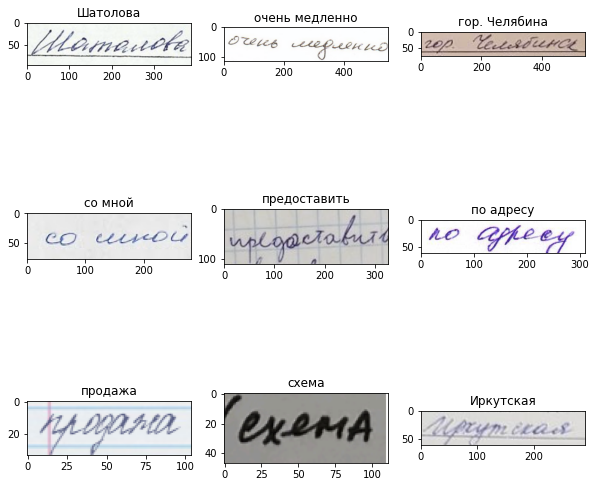

In [16]:
df = pd.read_csv(DIR+'/predictions.tsv', sep='\t', quoting=3)
N = 9
images = []
labels = []
for i in range(N):
    idx = random.randint(0, len(df))
    image_path = PATH_TEST_DIR + df.iloc[idx]['filename']
    predicted_label = df.iloc[idx]['prediction']

    images.append(Image.open(image_path))
    labels.append(predicted_label)

show_img_grid(images, labels, N)